# LFA to Guide the Ideal Interpolation and Test Functions (TFs)
The bootstrap process yields a sequence of interpolation operators. But how do we know that the interpolation approaches the optimal one (or a good enough one)? We need to set an end goal for bootstrap, so the following questions arise:
* What is the ideal set of TFs?
* Given infinite computational power to calculate the ideal test functions, how to determine the ideal interpolation $P$ from them?
* If an interpolation is not good enough, how can we use the current cycle to yield a new TF, determine if to add it to the TF set, and update $P$?

We use a combination of Local Fourier Analysis (LFA) and direct numerical predicion for simple cases first to gain intuition about the above questions.

In [226]:
%load_ext autoreload
%autoreload 2

import collections
import helmholtz as hm
import helmholtz.analysis
import numpy as np
import pandas as pd
import scipy.linalg
import matplotlib.pyplot as plt
from IPython.display import display

np.set_printoptions(linewidth=500, precision=2, suppress=False, threshold=100000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Poisson ($kh = 0$)
We employ a $3$-point (2nd order) and $5$-point (4th order).

### Mock Cycle - Gauss-Seidel

In [152]:
n = 96
aggregate_size = 2
num_examples = 2
num_windows = 10
threshold = 0.3
nu_values = np.arange(1, 5)
discretization_values = ("3-point", "5-point")
tv_values = ("relaxed", "ideal")

result = []
for discretization in discretization_values:
    for tv in tv_values:
        a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n).tocsr()
        relaxer = hm.solve.relax.GsRelaxer(a)
        level = hm.setup.hierarchy.create_finest_level(a, relaxer)
        x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
        b = np.zeros_like(x)
        if tv == "relaxed":
            x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=10)
        elif tv == "ideal":
            x, lam = hm.analysis.ideal.ideal_tv(a, num_examples)
        r, s = hm.repetitive.bootstrap_repetitive.create_repetitive_coarsening(
            x, num_windows, aggregate_size, threshold)
        print("discretization", discretization, "tv", tv)
        print("Singular values", s)
        print("r", r.asarray())
        print("-" * 50)
        r = r.tile(level.a.shape[0] // aggregate_size)
        result.append(np.array([
            hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in nu_values]))

mock_conv_factor = pd.DataFrame(np.array(result).transpose(), index=nu_values,
    columns=("{}-{}".format(discretization, tv) for discretization in discretization_values
            for tv in tv_values))
print("Mock Cycle Asymptotic Converegence Factor")
display(mock_conv_factor)

discretization 3-point tv relaxed
Singular values [0.08809914 0.01218129]
r [[0.69467197 0.71932667]]
--------------------------------------------------
discretization 3-point tv ideal
Singular values [0.51255521 0.01819813]
r [[0.69663863 0.71742221]]
--------------------------------------------------
discretization 5-point tv relaxed
Singular values [0.14033295 0.01204708]
r [[-0.68778065 -0.72591857]]
--------------------------------------------------
discretization 5-point tv ideal
Singular values [0.77212829 0.00458619]
r [[0.70990643 0.70429601]]
--------------------------------------------------
Mock Cycle Asymptotic Converegence Factor


,3-point-relaxed,3-point-ideal,5-point-relaxed,5-point-ideal
1,0.317568,0.308942,0.346493,0.338183
2,0.127171,0.127884,0.139235,0.143437
3,0.081997,0.080715,0.104380,0.103526
4,0.022447,0.023638,0.031061,0.029946


Looks like relaxed vectors gives the same result as ideal vectors. The rates follow the smoothing factor, so they make sense.

## Two-level LFA - Gauss Seidel

Two-level Cycle Asymptotic Converegence Factor


,3-point-galerkin,3-point-direct,5-point-galerkin,5-point-direct
1,0.666667,0.577350,0.726444,0.757351
2,0.555556,0.333333,0.627498,0.440031
3,0.518518,0.192450,0.591709,0.259196
4,0.506173,0.111111,0.578764,0.153947


Two-level Asymptotic Amplification Factor


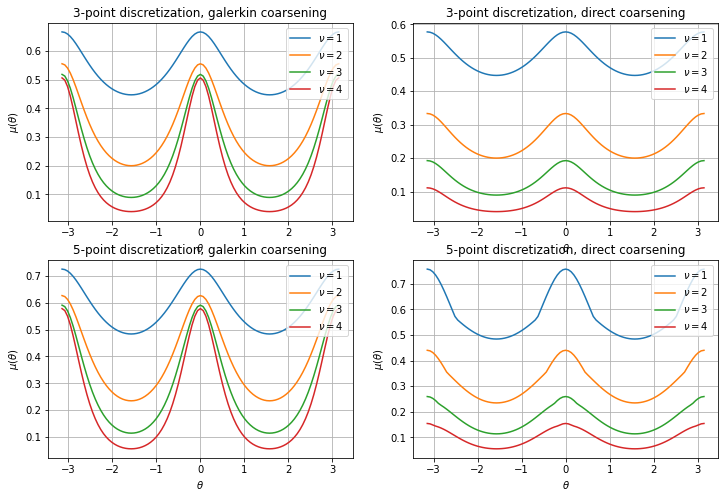

In [212]:
kh = 0
relax = "gs"
coarsening_values = ("galerkin", "direct")

conv_factor = []
two_level_mu = collections.OrderedDict()
for discretization in discretization_values:
    two_level_mu[discretization] = collections.OrderedDict()
    for coarsening in coarsening_values:
        lfa = helmholtz.analysis.lfa.LfaComputer(
            kh=0, discretization=discretization, relax=relax,
            restriction="constant", interpolation="constant", coarsening=coarsening)
        mu = [lfa.two_level_aymptotic_amplification(nu) for nu in nu_values]
        conv_factor.append([max(mu_i) for mu_i in mu])
        two_level_mu[discretization][coarsening] = mu
conv_factor = pd.DataFrame(np.array(conv_factor).transpose(), index=nu_values,
            columns=("{}-{}".format(discretization, coarsening) for discretization in discretization_values
                    for coarsening in coarsening_values))
print("Two-level Cycle Asymptotic Converegence Factor")
display(conv_factor)

fig, axs = plt.subplots(len(coarsening_values), len(discretization_values), 
                        figsize=(6 * len(coarsening_values), 4 * len(discretization_values)))
t = lfa.theta

print("Two-level Asymptotic Amplification Factor")
for i, discretization in enumerate(discretization_values):
    for j, coarsening in enumerate(coarsening_values):
        ax = axs[i, j]
        mu = two_level_mu[discretization][coarsening]
        for nu, mu_i in zip(nu_values, mu):
            ax.plot(t, mu_i, label=r"$\nu={}$".format(nu))
        ax.legend(loc="upper right")
        ax.set_xlabel(r"$\theta$")
        ax.set_ylabel(r"$\mu(\theta)$")
        ax.grid(True);
        ax.set_title("{} discretization, {} coarsening".format(discretization, coarsening))

In [242]:
# Two-level amplificaiton matrix, 2 relaxations per cycle, at theta ~ 0.
lfa = helmholtz.analysis.lfa.LfaComputer(
    kh=0, discretization="3-point", relax="gs",
    restriction="constant", interpolation="constant", coarsening="galerkin")
mu = [lfa.two_level_aymptotic_amplification(nu) for nu in nu_values]
print("Asymptotic convergence factor vs. nu")
print([max(mu_i) for mu_i in mu])

C = lfa.two_level_symbol(1e-5, 2)
print("C", C)
print("eigenvalues", np.linalg.eig(C)[0])

Asymptotic convergence factor vs. nu
[0.6666666528316397, 0.555555537074285, 0.5185184984547547, 0.5061728188814413]
C [[ 5.00e-01+0.00e+00j -4.60e-09-1.11e+04j]
 [-1.03e-18+2.50e-06j  5.56e-02+4.71e-23j]]
eigenvalues [ 5.56e-01+0.j -1.31e-17+0.j]


Observations:
* The smoothest eror component is the slowest error in the two-level cycle.
* We get a lower bound of $0.5$ convergence factor because the coarse-level operator is a **Galerkin operator based on first-order transfers** and the eigenvalue ratio is $\lambda^h/\lambda^{2h} \approx 0.5$. If $A^{2h}$ is a direct PDE discretization, cycle convergence actually improves with $\nu$ up to $0.1$ convergence factor. **Even with a first-order $P$, an energy-corrected coarse operator attains the ideal two-level rates, slightly better than predicted by the mock cycle.**
* The high-order $5$-point discretization shows similar, slightly worse results to the $3$-point discretization.

#### Sanity Check: Linear Interpolation + Constant Transfers + Galerkin
Should result in rates that don't depend on the smoothest components. Indeed:

Asymptotic convergence factor vs. nu
[0.4472135954963803, 0.21212092628127951, 0.14157210392383396, 0.11518397372060551]
Two-level Asymptotic Amplification Factor


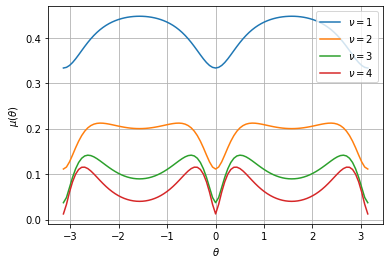

In [239]:
lfa = helmholtz.analysis.lfa.LfaComputer(
    kh=0, discretization="3-point", relax="gs",
    restriction="constant", interpolation="linear", coarsening="galerkin")
mu = [lfa.two_level_aymptotic_amplification(nu) for nu in nu_values]
print("Asymptotic convergence factor vs. nu")
print([max(mu_i) for mu_i in mu])

print("Two-level Asymptotic Amplification Factor")
for nu, mu_i in zip(nu_values, mu):
    plt.plot(t, mu_i, label=r"$\nu={}$".format(nu))
plt.legend(loc="upper right")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mu(\theta)$")
plt.grid(True);

In [243]:
# Two-level amplificaiton matrix, 2 relaxations per cycle, at theta ~ 0
C = lfa.two_level_symbol(1e-5, 2)
print("C", C)
print("eigenvalues", np.linalg.eig(C)[0])

C [[ 5.00e-01+0.00e+00j -4.60e-09-1.11e+04j]
 [-1.03e-18+2.50e-06j  5.56e-02+4.71e-23j]]
eigenvalues [ 5.56e-01+0.j -1.31e-17+0.j]


#### Mock Cycle - Kaczmarz
We create a repetitive coarsening from 2 relaxed TFs (10 sweeps, starting from random), 10 windows each. The SVD accuracy threshold is high on purpose ($30\%$) so we can get a single PC here and can compare it to LFA with piecewise constant interpolation = $R^T$.

In [151]:
n = 96
aggregate_size = 2
num_examples = 2
num_windows = 10
threshold = 0.3
nu_values = np.arange(1, 5)
discretization_values = ("3-point", "5-point")
tv_values = ("relaxed", "ideal")

result = []
for discretization in discretization_values:
    for tv in tv_values:
        a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n).tocsr()
        level = hm.setup.hierarchy.create_finest_level(a)
        x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
        b = np.zeros_like(x)
        if tv == "relaxed":
            x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=10)
        elif tv == "ideal":
            x, lam = hm.analysis.ideal.ideal_tv(a, num_examples)
        r, s = hm.repetitive.bootstrap_repetitive.create_repetitive_coarsening(
            x, num_windows, aggregate_size, threshold)
        print("discretization", discretization, "tv", tv)
        print("Singular values", s)
        print("r", r.asarray())
        print("-" * 50)
        r = r.tile(level.a.shape[0] // aggregate_size)
        result.append(np.array([
            hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in nu_values]))

mock_conv_factor = pd.DataFrame(np.array(result).transpose(), index=nu_values,
    columns=("{}-{}".format(discretization, tv) for discretization in discretization_values
            for tv in tv_values))
print("Mock Cycle Asymptotic Converegence Factor")
display(mock_conv_factor)

discretization 3-point tv relaxed
Singular values [0.20805324 0.05552985]
r [[-0.7239724  -0.68982894]]
--------------------------------------------------
discretization 3-point tv ideal
Singular values [0.51255521 0.01819813]
r [[0.69663863 0.71742221]]
--------------------------------------------------
discretization 5-point tv relaxed
Singular values [0.21476904 0.04667459]
r [[0.71103938 0.70315218]]
--------------------------------------------------
discretization 5-point tv ideal
Singular values [0.77212829 0.00458619]
r [[0.70990643 0.70429601]]
--------------------------------------------------
Mock Cycle Asymptotic Converegence Factor


,3-point-relaxed,3-point-ideal,5-point-relaxed,5-point-ideal
1,0.466643,0.466787,0.550570,0.543483
2,0.211905,0.210504,0.238859,0.237837
3,0.192529,0.194223,0.207996,0.204324
4,0.168450,0.165579,0.191750,0.194764


Again, according to the mock cycle prediction, relaxed vectors, even with Kaczmarz relaxation, are sufficient to obtain a good enough coarsening operator $R$ (up to $\approx 0.2$ convergence per cycle). Using the smallest vectors doesn't change much.

### Two-level LFA - Kaczmarz

Two-level Cycle Asymptotic Converegence Factor


,3-point-galerkin,3-point-direct,5-point-galerkin,5-point-direct
1,0.728803,0.679705,0.780309,0.890805
2,0.603890,0.461998,0.672970,0.602925
3,0.547135,0.314022,0.620853,0.411821
4,0.521379,0.213442,0.595486,0.292394


Two-level Asymptotic Amplification Factor


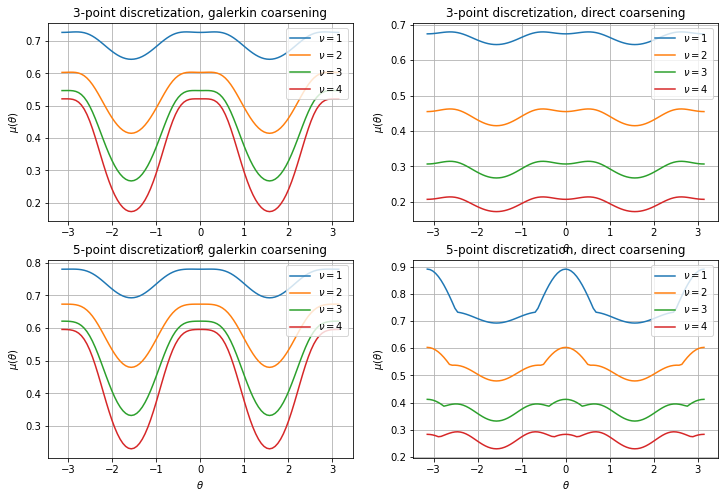

In [153]:
kh = 0
relax = "relax"
coarsening_values = ("galerkin", "direct")

conv_factor = []
two_level_mu = collections.OrderedDict()
for discretization in discretization_values:
    two_level_mu[discretization] = collections.OrderedDict()
    for coarsening in coarsening_values:
        lfa = helmholtz.analysis.lfa.LfaComputer(
            kh=0, discretization=discretization, relax=relax,
            restriction="constant", interpolation="constant", coarsening=coarsening)
        mu = [lfa.two_level_aymptotic_amplification(nu) for nu in nu_values]
        conv_factor.append([max(mu_i) for mu_i in mu])
        two_level_mu[discretization][coarsening] = mu
conv_factor = pd.DataFrame(np.array(conv_factor).transpose(), index=nu_values,
            columns=("{}-{}".format(discretization, coarsening) for discretization in discretization_values
                    for coarsening in coarsening_values))
print("Two-level Cycle Asymptotic Converegence Factor")
display(conv_factor)

fig, axs = plt.subplots(len(coarsening_values), len(discretization_values), 
                        figsize=(6 * len(coarsening_values), 4 * len(discretization_values)))
t = lfa.theta

print("Two-level Asymptotic Amplification Factor")
for i, discretization in enumerate(discretization_values):
    for j, coarsening in enumerate(coarsening_values):
        ax = axs[i, j]
        mu = two_level_mu[discretization][coarsening]
        for nu, mu_i in zip(nu_values, mu):
            ax.plot(t, mu_i, label=r"$\nu={}$".format(nu))
        ax.legend(loc="upper right")
        ax.set_xlabel(r"$\theta$")
        ax.set_ylabel(r"$\mu(\theta)$")
        ax.grid(True);
        ax.set_title("{} discretization, {} coarsening".format(discretization, coarsening))

The results are very similar to Gauss-Seidel, albeit worse, as Kaczmarz is a less efficient smoother. 

So, the bootstrap process would produce an initial cycle that converges no better than $0.5$, and the slowest error would be the smoothest vector (especially if it is obtained after fine-level post-smoothing). **Since we already built $P$ using the constant vector, how would adding this new vector help in improving it, if it's also nearly constant?** In other words, would the TF set be enriched so that the interpolation can now reproduce linear functions, not just constant (i.e., its order is increased)?

## Improved Interpolation
Work in progress; fit interpolation into 2 components - the constant and slowest component (which is also smooth); do we get better rates?

In [244]:
# n = 96
# aggregate_size = 2
# nc = 1
# caliber = 2
# discretization = "3-point"
# num_examples = 2
# num_windows = 10

# # Build coarsening using relaxed vectors.
# a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n).tocsr()
# level = hm.setup.hierarchy.create_finest_level(a)
# x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
# b = np.zeros_like(x)
# x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=10)
# r, s = hm.repetitive.bootstrap_repetitive.create_repetitive_coarsening(
#     x, num_windows, aggregate_size, threshold)
# num_aggregates = a.shape[0] // aggregate_size
# r_csr = r.tile(num_aggregates)

# # Build interpolation using the two smallest eigenvectors. 
# num_examples = 2
# x, lam = hm.analysis.ideal.ideal_tv(a, num_examples)

# # p, fit_error, val_error, test_error, alpha_opt = \
# #     hm.setup.interpolation.create_interpolation_least_squares_auto_nbhrs(x, a, r_csr)

# xc = r_csr.dot(x)
# num_coarse_vars = xc.shape[0]
# print(x.shape)
# print(xc.shape)
# x_window_t = np.concatenate(tuple(hm.linalg.get_window(x, aggregate_size * offset, aggregate_size)
#                                               for offset in range(num_windows)), axis=1).transpose()
# xc_window_t = np.concatenate(tuple(hm.linalg.get_window(xc, offset, num_coarse_vars)
#                                                for offset in range(num_windows)), axis=1).transpose()
# print(x_window_t.shape)
# print(xc_window_t.shape)
# # p = hm.setup.interpolation.create_interpolation(
# #     "ls", r.asarray(), x_disjoint_aggregate_t, xc_disjoint_aggregate_t,
# #     a.shape[0], nc, caliber)
# # multilevel = hm.hierarchy.multilevel.Multilevel(level)
# # coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
# # multilevel.level.append(coarse_level)

In [245]:
# print(x_window_t.shape, x.shape, xc_window_t.shape)
# num_samples = x_window_t.shape[0]
# nbhr = [np.unique(r_csr[:, a[i].nonzero()[1]].nonzero()[0]) for i in range(x.shape[1])]
# print("nbhr", nbhr)

# # Ridge regularization parameter (list of values).
# alpha = np.array([0, 0.01, 0.1, 0.1, 1])
# num_examples = x.shape[1]
# hm.setup.interpolation_fit.create_interpolation_least_squares(
#     x_window_t, xc_window_t, nbhr, alpha,
#     fit_samples=int(0.5 * num_samples),
#     val_samples=int(0.25 * num_samples),
#     test_samples=int(0.25 * num_samples))

In [246]:
# y = np.random.random((20, 2))
# yc = np.random.random((10, 2))
# nc = n // 2
# alpha = [0, 0.1, 0.2, 1.0]
# p, fit_error, val_error, test_error, alpha_opt = \
#     hm.setup.interpolation_fit.create_interpolation_least_squares(y, yc, nbhr, alpha)